# CLIP(Contrastive Language–Image Pre-training) in AutoMM

OpenAI는 2021년 1월 DALL-E와 CLIP이라는 놀라운 모델을 공개했습니다. CLIP은 (이미지, 텍스트) 쌍에 대해 이미지와 텍스트를 각각의 인코더를 거쳐 임베딩 벡터로 변환하고(이미지: ResNet or Vision Transformer, 텍스트: Transformer), 내적(코사인 유사도)을 통해 둘 사이의 유사도를 학습합니다.

Pre-training 단계에서는 약 4억 개의 (이미지, 텍스트) 쌍에 대해, positive 쌍의 유사도를 최대하고 negative 쌍의 유사도를 최소화하도록 Symmetric Cross Entropty loss로 학습합니다. Zero-shot 추론 단계에서는 입력 이미지 임베딩과 k개 텍스트 임베딩 사이의 코사인 유사도 점수를 계산하여 가장 높은 유사도를 가지는 텍스트를 선택합니다.

![CLIP](./imgs/clip.png)  

CLIP은 별도의 정답 클래스에 대한 정보가 필요하지 않고 추론 시에는 코사인 유사도만 온라인으로 수행하면 되므로 확장성이 용이합니다. 또한, 파인튜닝이 필요 없는 zero-shot 모델임에도 ImageNet ResNet50의 Top-1 accuracy에 견주는 정확도를 보입니다. AutoGluon은 0.5.1 버전부터 CLIP 모델을 API 호출로 쉽게 사용할 수 있습니다.
- https://arxiv.org/abs/2103.00020

<br>

## 1. Zero-shot Image Classification

### Simple prediction

In [1]:
save_path = 'ag-04-clip-zeroshot'
sample_path = 'sample_imgs'
!rm -rf $save_path

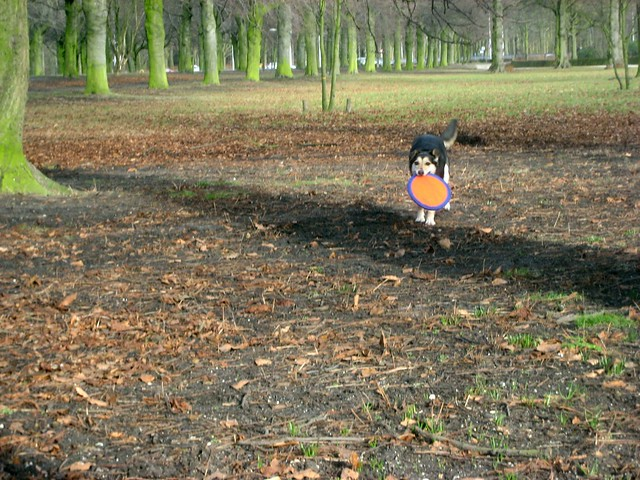

In [2]:
from IPython.display import Image, display
from autogluon.multimodal import download
import numpy as np

def softmax(x, axis=1):
    return np.exp(x) / np.sum(np.exp(x), axis=axis)

url = "https://farm4.staticflickr.com/3445/3262471985_ed886bf61a_z.jpg"
dog_image = download(url, path=sample_path)

pil_img = Image(filename=dog_image)
display(pil_img)

In [3]:
from autogluon.multimodal import MultiModalPredictor

predictor = MultiModalPredictor(hyperparameters={"model.names": ["clip"]}, problem_type="zero_shot")
prob = predictor.predict_proba(
    {"image": [dog_image]}, 
    {"text": ['This is a Husky', 'This is a Golden Retriever', 'This is a German Sheperd', 'This is a Samoyed.']}
)
print("Label probs:", softmax(prob))

Downloading:   0%|          | 0.00/4.42k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/844 [00:00<?, ?B/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Label probs: [[0.3331884  0.18886325 0.28614086 0.19180752]]


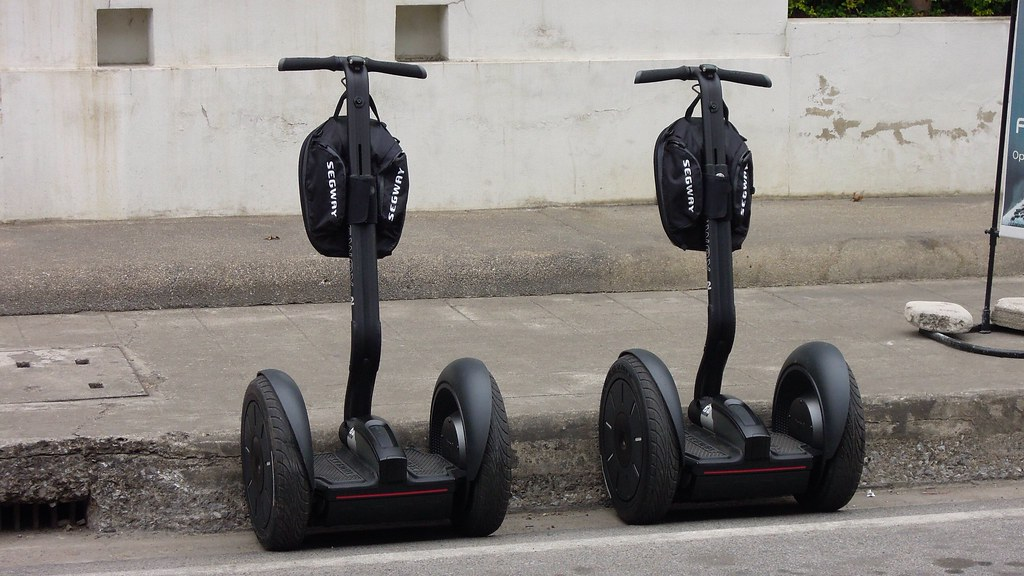

In [4]:
url = "https://live.staticflickr.com/7236/7114602897_9cf00b2820_b.jpg"
segway_image = download(url, path=sample_path)

pil_img = Image(filename=segway_image)
display(pil_img)

In [5]:
prob = predictor.predict_proba({"image": [segway_image]}, {"text": ['segway', 'bicycle', 'wheel', 'car']})
print("Label probs:", softmax(prob))

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Label probs: [[0.4753574  0.17488024 0.17488275 0.17487961]]


<br>

## 2. Limitations of CLIP

CLIP은 이미지에 텍스트 정보가 포함되어 있을 때, 추론 결과에 영향을 크게 받습니다. 사과 이미지로 간단한 테스트를 수행하겠습니다.

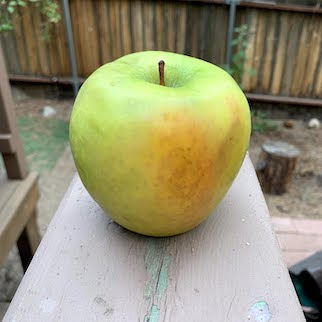

In [6]:
url = "https://cdn.openai.com/multimodal-neurons/assets/apple/apple-blank.jpg"
image_path = download(url, path=sample_path)

pil_img = Image(filename=image_path)
display(pil_img)

In [7]:
prob = predictor.predict_proba({"image": [image_path]}, {"text": ['', 'iPod', 'library', 'pizza', 'toaster', 'dough']})
print("Label probs:", softmax(prob))

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Label probs: [[0.18262194 0.25219458 0.1385816  0.14044295 0.1424387  0.14372024]]


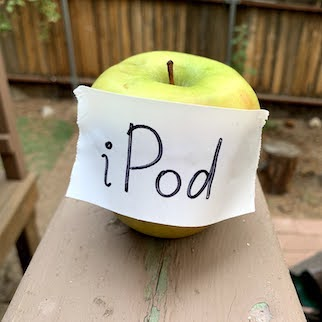

In [8]:
url = "https://cdn.openai.com/multimodal-neurons/assets/apple/apple-ipod.jpg"
image_path = download(url, path=sample_path)

pil_img = Image(filename=image_path)
display(pil_img)

사과 대신 아이팟을 예측했습니다.

In [9]:
prob = predictor.predict_proba({"image": [image_path]}, {"text": ['Granny Smith', 'iPod', 'library', 'pizza', 'toaster', 'dough']})
print("Label probs:", softmax(prob))

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Label probs: [[0.13348334 0.34548306 0.13025616 0.1302559  0.13025951 0.13026202]]


<br>

## 3. Image Retrieval by Text Query
    
데모 예시로 5개의 이미지 임베딩과 1개의 텍스트 임베딩에 대해 유사도를 계산합니다.

### Example (1)

In [10]:
from autogluon.multimodal import download

urls = ['http://farm4.staticflickr.com/3179/2872917634_f41e6987a8_z.jpg', # Cat
        'http://farm4.staticflickr.com/3629/3608371042_75f9618851_z.jpg', # Builiding
        'https://farm4.staticflickr.com/3795/9591251800_9c9727e178_z.jpg', # Carriage
        'http://farm8.staticflickr.com/7188/6848765123_252bfca33d_z.jpg', # Bicycle
        'https://farm6.staticflickr.com/5251/5548123650_1a69ce1e34_z.jpg'] # Airplane

image_paths = [download(url, path=sample_path) for url in urls]
print(image_paths)

['sample_imgs/2872917634_f41e6987a8_z.jpg', 'sample_imgs/3608371042_75f9618851_z.jpg', 'sample_imgs/9591251800_9c9727e178_z.jpg', 'sample_imgs/6848765123_252bfca33d_z.jpg', 'sample_imgs/5548123650_1a69ce1e34_z.jpg']


In [11]:
# extract image embeddings
image_embeddings = predictor.extract_embedding({"image": image_paths})

# extract text embeddings
text_embeddings = predictor.extract_embedding({"text": ["There's a cat under the car."]})

image_features = image_embeddings['image']
text_features = text_embeddings['text']

print(image_features.shape)  # image (5, 768)
print(text_features.shape)  # text (1, 768)

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

(5, 768)
(1, 768)


In [12]:
import numpy as np
similarity = np.matmul(image_features, text_features.T)
max_sim_idx = np.argmax(similarity)

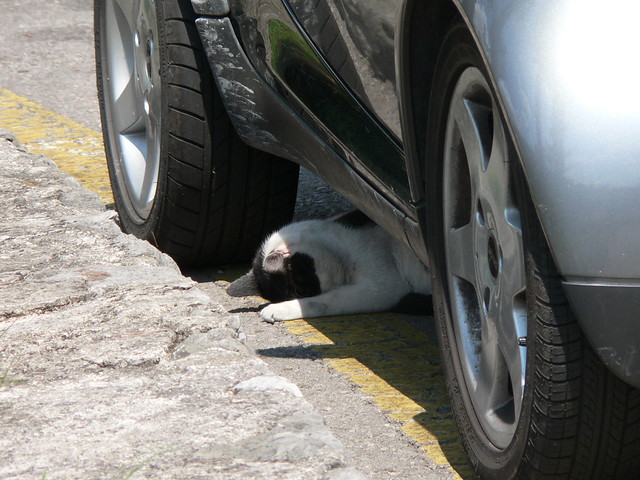

In [13]:
from IPython.display import Image, display
pil_img = Image(filename=image_paths[max_sim_idx])
display(pil_img)

### Example (2)

In [14]:
text_embeddings = predictor.extract_embedding({"text": ['There is an airplane over a car.']})
text_features = text_embeddings['text']
similarity = np.matmul(image_features, text_features.T)
max_sim_idx = np.argmax(similarity)

Predicting: 0it [00:00, ?it/s]

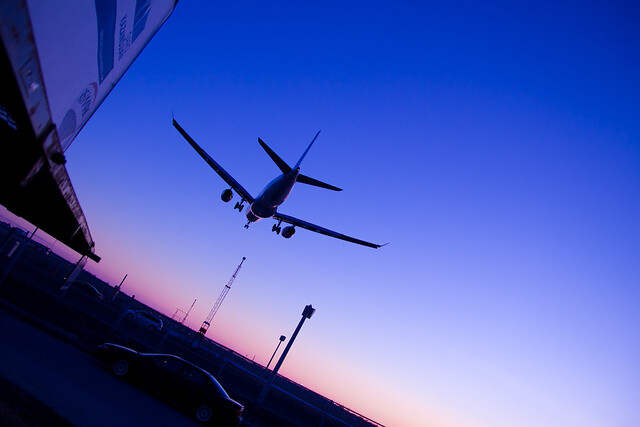

In [15]:
pil_img = Image(filename=image_paths[max_sim_idx])
display(pil_img)